In [172]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

In [173]:
# user defined functions

# remove the top and bottom 5% of data
def removeExtreme(df, column):
    max_ = df[column].quantile(0.95)
    min_ = df[column].quantile(0.05)
    return df[(df[column] > min_) & (df[column] < max_)]

# create a distribution of bootstrapped sample means 
def bootstrap(df, column, iterations):
    bootstap_mean = []
    for _ in range(iterations):
        data = np.random.choice(df[column], replace = True, size = iterations)
        bootstap_mean.append(np.mean(data))
    return bootstap_mean 

In [198]:
# define parameters 

ticker = 'SPY'
startDate = '2015-01-01'
endDate = '2022-12-31'
dataInterval = '1d'

fastSMA = 9
normalSMA = 50
slowSMA = 200

# moving average period
rollingPeriod = 21

# entry ratio
entryPercentile = 0.10

# exit ratio
exitPercentile = 0.90

In [211]:
# get data
df = yf.download(ticker, startDate, endDate, interval = dataInterval)
df.reset_index(inplace=True)

[*********************100%***********************]  1 of 1 completed


In [212]:
# add indicators to dataframe
df['fastSMA'] = df['Close'].rolling(fastSMA).mean()
df['normalSMA'] = df['Close'].rolling(normalSMA).mean()
df['slowSMA'] = df['Close'].rolling(slowSMA).mean()

# drop nulls
df.dropna(inplace=True)
df.reset_index(inplace=True, drop = True)

In [213]:
# calculate the area between slow and fast sma
df['spead_fastSMA_normalSMA'] =  (df['fastSMA'] - df['normalSMA']) / abs(df['Close'] - df['normalSMA'])
df['spead_slowSMA_normalSMA'] =  (df['slowSMA'] - df['normalSMA']) / abs(df['Close'] - df['normalSMA'])

# remove extreme obs
df = removeExtreme(df, 'spead_fastSMA_normalSMA')
df = removeExtreme(df, 'spead_slowSMA_normalSMA')

In [214]:
# define trend 
# slow crossed over fast
df['slowFast_CrossedOver'] = 'No'
df.loc[df['slowSMA'] >= df['fastSMA'], 'slowFast_CrossedOver'] = 'Yes'

# slow crossed over normal
df['slowNormal_CrossedOver'] = 'No'
df.loc[df['slowSMA'] >= df['normalSMA'], 'slowNormal_CrossedOver'] = 'Yes'

# fast crossed over normal
df['fastNormal_CrossedOver'] = 'No'
df.loc[df['fastSMA'] >= df['normalSMA'], 'fastNormal_CrossedOver'] = 'Yes'

# bootstap dataset and calculate sample means
spead_fastSMA_normalSMA_bootstrapped_mean = bootstrap(df, 'spead_fastSMA_normalSMA', 1000)
spead_slowSMA_normalSMA_bootstrapped_mean = bootstrap(df, 'spead_slowSMA_normalSMA', 1000)

# reset index
df.reset_index(inplace=True, drop = True)

In [215]:
# get the date of when the cross over occured
# create empty placeholder initalized with the first period
period = [df['Date'][0]]
keyDate = []
for i in range(len(df) - 1):
    
    # get current and prior status
    currentStatus = df['fastNormal_CrossedOver'][i+1]
    priorStatus = df['fastNormal_CrossedOver'][i]
    
    # if the status has not changed
    if currentStatus == priorStatus:
        # then set the current period equal to the prior one
        period.append(period[-1])
        keyDate.append(0)
    # if there has been a crossover
    else:
        period.append(df['Date'][i+1])
        keyDate.append(1)
keyDate.append(0)
        
# cross over key date?  
df['Date_fastNormal_CrossedOver_key_Date'] = keyDate
# date when cross over occured    
df['Date_fastNormal_CrossedOver'] = period

In [216]:
# merge df to get the Closing price of crossover date
data = df[['Date','Close']].copy()
data.columns = ['Date_fastNormal_CrossedOver','Close_fastNormal_CrossedOver']
df = df.merge(data, how = 'left', left_on = 'Date_fastNormal_CrossedOver', right_on = 'Date_fastNormal_CrossedOver')


In [217]:
# ROI from when the crossover occured
df['ROI_fastNormal_CrossedOver'] = df['Close'] / df['Close_fastNormal_CrossedOver'] - 1

In [226]:
# ROI if strategy was in place
roi = df.loc[df['Date_fastNormal_CrossedOver_key_Date']==1]

In [237]:
keyColumns = ['Date_fastNormal_CrossedOver','Date','Days_Spread','ROI_fastNormal_CrossedOver',
              'slowFast_CrossedOver','fastNormal_CrossedOver','slowNormal_CrossedOver',]

roi['Days_Spread'] = roi['Date'] - roi['Date_fastNormal_CrossedOver']
roi[keyColumns].sort_values('ROI_fastNormal_CrossedOver')

<ipython-input-237-75b51345aa4d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roi['Days_Spread'] = roi['Date'] - roi['Date_fastNormal_CrossedOver']


,Date_fastNormal_CrossedOver,Date,Days_Spread,ROI_fastNormal_CrossedOver,slowFast_CrossedOver,fastNormal_CrossedOver,slowNormal_CrossedOver
1400,2022-04-22,2022-06-30,69 days,-0.114520,Yes,No,Yes
952,2020-02-27,2020-04-21,54 days,-0.082249,Yes,No,Yes
72,2015-12-15,2016-02-16,63 days,-0.074379,Yes,No,Yes
1054,2020-10-09,2020-10-28,19 days,-0.058210,No,Yes,No
681,2018-10-11,2019-01-08,89 days,-0.056582,Yes,No,Yes
1437,2022-09-15,2022-10-21,36 days,-0.040577,Yes,No,Yes
825,2019-09-10,2019-10-03,23 days,-0.025861,No,Yes,No
1360,2022-03-25,2022-04-19,25 days,-0.016899,Yes,Yes,Yes
1349,2022-01-18,2022-03-24,65 days,-0.013144,Yes,No,Yes
561,2018-05-14,2018-07-03,50 days,-0.007620,No,Yes,No


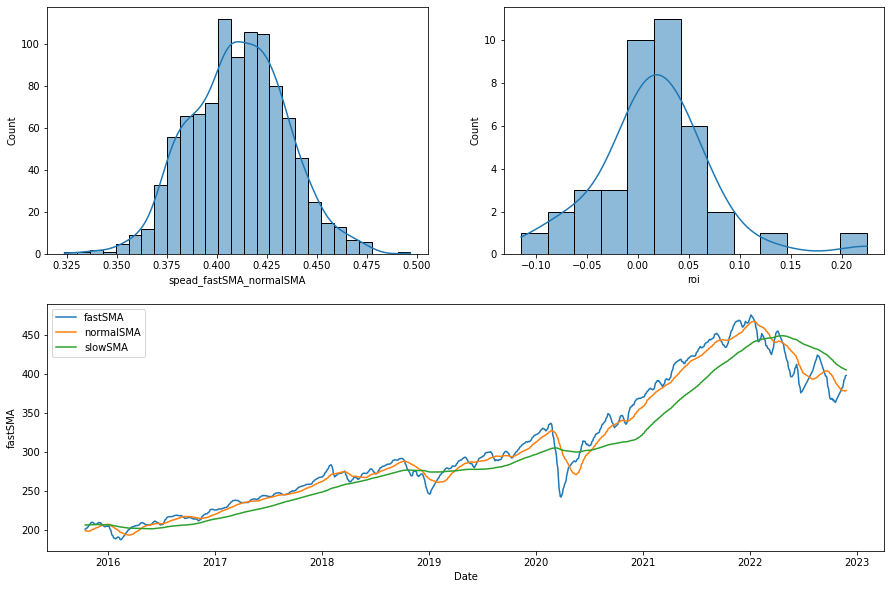

In [224]:
fig = plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
sns.histplot(spead_fastSMA_normalSMA_bootstrapped_mean, kde=True).set(xlabel='spead_fastSMA_normalSMA')

plt.subplot(2,2,2)
sns.histplot(roi, kde=True).set(xlabel='roi')

plt.subplot(2,1,2)
sns.lineplot(x=df['Date'],y=df['fastSMA'], label='fastSMA')
sns.lineplot(x=df['Date'],y=df['normalSMA'], label='normalSMA')
sns.lineplot(x=df['Date'],y=df['slowSMA'], label='slowSMA')


plt.show()


In [142]:
df.groupby(['fastNormal_CrossedOver','slowFast_CrossedOver','slowNormal_CrossedOver']).count()[['Date']]

Date
fastNormal_CrossedOver slowFast_CrossedOver slowNormal_CrossedOver      
No                     No                   No                       175
                       Yes                  No                        70
                                            Yes                      130
Yes                    No                   No                       889
                                            Yes                      108
                       Yes                  Yes                       77